This notebook built and test three different models (Multiple Linear Regression, Lasso Regression and Random Forest) on data from `DS_salary_cleaned.csv`, among which random forest has the best performance. Steps include:
- transformed categorical variables into dummy variables
- split data into train and test sets
- applied Multiple Linear Regression as baseline, used Mean Absolute Error for evaluation
- applied Lasso Regression, optimized alpha parameter with for loop and plot visualization
- applied Random Forest, optimized `n_estimators`, `criterion` and `max_features` parameters with GridsearchCV
- evaluated model performances from three approaches, where Random Forest outperformed than other approaches

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('DS_salary_cleaned.csv')
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'min_salary', 'max_salary', 'avg_salary', 'company_txt',
       'job_state', 'same_state', 'age', 'python_yn', 'sql_yn', 'excel_yn',
       'aws_yn', 'spark_yn', 'nlp_yn', 'rstudio_yn', 'job_simp', 'seniority',
       'description_length', 'num_competitor'],
      dtype='object')

In [3]:
# choose columns
df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry',
               'Sector','Revenue','num_competitor','hourly', 'job_state',
               'same_state','age','python_yn','sql_yn','excel_yn','aws_yn',
               'nlp_yn', 'job_simp','seniority','description_length']]

In [4]:
# one hot encoding for categorical variables
df_dum = pd.get_dummies(df_model)

# train test split
X = df_dum.drop('avg_salary',axis = 1)
y = df_dum.avg_salary.values
[X_train, X_test, y_train, y_test] = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [5]:
# multiple linear regression using stats
X_sm = sm.add_constant(X_train)
model = sm.OLS(y_train,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     7.491
Date:                Sun, 12 Jul 2020   Prob (F-statistic):           2.12e-60
Time:                        14:01:31   Log-Likelihood:                -2641.8
No. Observations:                 593   AIC:                             5560.
Df Residuals:                     455   BIC:                             6165.
Df Model:                         137                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                42.6984      6.464      6.606      0.000      29.996      55.401
Rating                                                1.4444      2.214      0.653      0.514      -2.906       5.794
num_competitor                                        3.8909      1.507      2.581      0.010       0.929       6.853
hourly                                              -14.2759     11.328     -1.260      0.208     -36.538       7.986
same_state                                            2.9069      3.084      0.942      0.346      -3.155       8.968
age                                                   0.0265      0.034      0.772      0.440      -0.041       0.094
python_yn                                             9.7402      2.945      3.308      0.001       3.953      15.527
sql_yn                                               -2.5652      2.939     -0.873      0.383      -8.341       3.211
excel_yn                                              2.7257      2.695      1.011      0.312      -2.570       8.022
aws_yn                                                2.0123      3.120      0.645      0.519      -4.119       8.143
nlp_yn                                                0.4495      5.499      0.082      0.935     -10.357      11.256
description_length                                   -0.0002      0.001     -0.284      0.776      -0.002       0.001
Size_-1                                            6.476e-14   4.45e-14      1.457      0.146   -2.26e-14    1.52e-13
Size_1 to 50 employees                                0.2294      7.918      0.029      0.977     -15.331      15.790
Size_10000+ employees                                -1.9052      6.488     -0.294      0.769     -14.656      10.846
Size_1001 to 5000 employees                           5.4956      4.251      1.293      0.197      -2.859      13.851
Size_201 to 500 employees                            -2.1013      4.232     -0.497      0.620     -10.418       6.215
Size_5001 to 10000 employees                         -4.9136      6.081     -0.808      0.419     -16.863       7.036
Size_501 to 1000 employees                           -3.1002      4.584     -0.676      0.499     -12.108       5.908
Size_51 to 200 employees                              5.7790      4.848      1.192      0.234      -3.748      15.306
Size_Unknown                                         43.2149     17.117      2.525      0.012       9.576      76.854
Type of ownership_-1                               2.243e-14   4.72e-14      0.475      0.635   -7.03e-14    1.15e-13
Type of ownership_College / University                7.0052     19.339      0.362      0.717     -30.999      45.010
Type of ownersh

In [6]:
# multiple linear regression using sklearn
lm = LinearRegression()
lm.fit(X_train,y_train)

np.mean(-1 * cross_val_score(lm,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3))

22.27288570844212

In [7]:
# Lasso regression
lm_Lasso = Lasso()
np.mean(-1 * cross_val_score(lm_Lasso,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3))

21.565034284108105

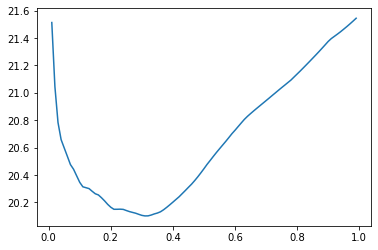

In [8]:
# loop to check out optimized alpha in Lasso model
alpha = []
error = []

for i in np.arange(0.01,1,0.01):
    alpha.append(i)
    lm_Lasso = Lasso(alpha = i)
    error.append(np.mean(-1 * cross_val_score(lm_Lasso,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3)))
    
plt.plot(alpha,error);

In [14]:
optimal_alpha = alpha[np.argmin(error)]
lm_Lasso_opt = Lasso(alpha = optimal_alpha)
lm_Lasso_opt.fit(X_train,y_train)
np.mean(-1 * cross_val_score(lm_Lasso_opt,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3))

20.101443994245873

In [10]:
# random forest model
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
np.mean(-1 * cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3))

15.81252632073698

In [11]:
# tune RF model with GridsearchCV
parameters = {'n_estimators': range(10,200,10),
              'criterion': ('mse', 'mae'),
              'max_features': ('auto','sqrt', 'log2')}

gs = GridSearchCV(rf, parameters, scoring = 'neg_mean_absolute_error',cv=3)
gs.fit(X_train,y_train)

print(-1 * gs.best_score_)

15.330157904314369


In [12]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=170, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [13]:
# test all 3 methods
tpred_lm = lm.predict(X_test)
tpred_lml = lm_Lasso_opt.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

print("Multiple Linear Regression MAE = %.2f" % mean_absolute_error(y_test,tpred_lm))
print("Lasso Regression MAE = %.2f" % mean_absolute_error(y_test,tpred_lml))
print("Random Forest MAE = %.2f" % mean_absolute_error(y_test,tpred_rf))

Multiple Linear Regression MAE = 303045468.79
Lasso Regression MAE = 18.70
Random Forest MAE = 12.49
